# Config

In [1]:
# Set dark mode as default
import matplotlib.pyplot as plt
import plotly.io as pio
plt.style.use("dark_background")
pio.templates.default = "plotly_dark"

# Imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyts.image import RecurrencePlot, GramianAngularField

from market_regime.features.image_features import transform_price

# Global variables
REPO_DIR: Path = Path("..").resolve()
assert REPO_DIR.name == "market-regime-classification", "`REPO_DIR` points to incorrect folder."
DATA_PATH: Path = REPO_DIR / "data/preprocessed"

# Data

### data import

In [2]:
# Data import (with labels)
df = pd.read_csv(DATA_PATH / "daily_prices_with_labels.csv").set_index("trading_date").sort_index()

### data scaling

<Axes: xlabel='trading_date'>

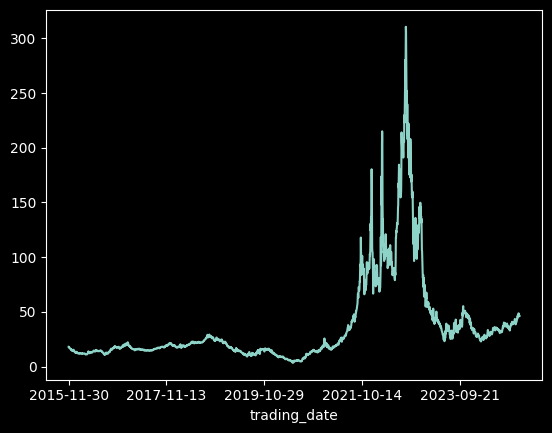

In [3]:
df["close"].plot()

<Axes: xlabel='trading_date'>

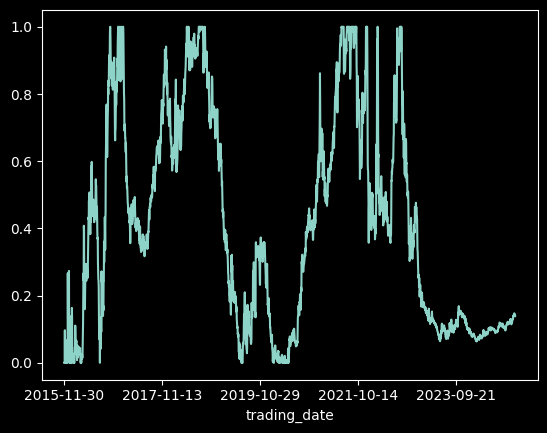

In [4]:
# using min max (needed for GAF, can be used for RP)
(
    (df["close"] - df["close"].expanding().min())
    / (df["close"].expanding().max() - df["close"].expanding().min())
).plot()

<Axes: xlabel='trading_date'>

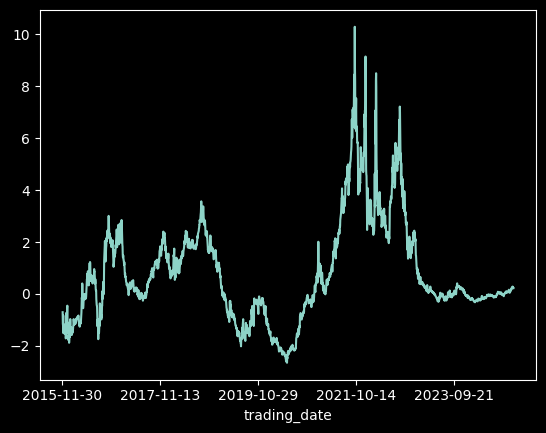

In [5]:
# using z-score (can be used with RP)
((df["close"] - df["close"].expanding().mean()) / df["close"].expanding().std()).plot()

<Axes: xlabel='trading_date'>

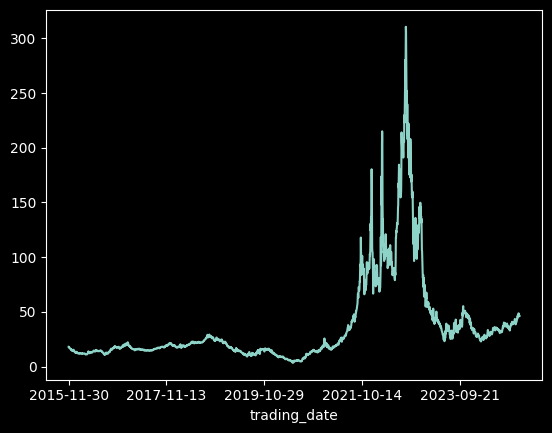

In [6]:
df["close"].plot()

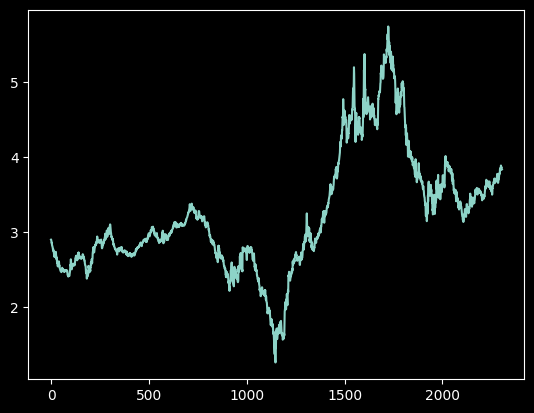

In [7]:
plt.plot(np.log(df["close"].to_numpy()))

### recurrence plot

In [9]:
df.shape

(2305, 4)

In [10]:
x = df["close"].to_numpy()

In [11]:
x.dtype

dtype('float64')

In [12]:
y = df["target"].to_numpy(dtype=int)

In [13]:
y.dtype

dtype('int64')

In [14]:
x_rp = transform_price(x, scale_method="zscore", keepdims=True)

In [15]:
x_rp

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-1.2465404 , -1.17889522, -1.0345142 , ...,  1.7125464 ,
         1.93354766,  1.62978347],
       [-1.21748458, -1.0741521 , -0.8275031 , ...,  1.87235463,
         1.57079648,  1.54441644],
       [-1.11349414, -0.86815007, -1.33925962, ...,  1.51746102,
         1.49122055,  1.44542986]], shape=(2305, 60))

In [16]:
np.isnan(x_rp).any(axis=1)

array([ True,  True,  True, ..., False, False, False], shape=(2305,))

In [17]:
rp_transformer = RecurrencePlot()
x_rp_t = rp_transformer.fit_transform(x_rp)  # x_rp: (T, window)

ValueError: Input contains NaN.

In [ ]:
x_rp_t.shape

(2246, 60, 60)

In [ ]:
x_rp_t[0]

array([[0.        , 0.02201733, 0.21165827, ..., 2.98933296, 3.07290731,
        3.23612929],
       [0.02201733, 0.        , 0.18964094, ..., 2.96731563, 3.05088998,
        3.21411196],
       [0.21165827, 0.18964094, 0.        , ..., 2.7776747 , 2.86124904,
        3.02447102],
       ...,
       [2.98933296, 2.96731563, 2.7776747 , ..., 0.        , 0.08357434,
        0.24679633],
       [3.07290731, 3.05088998, 2.86124904, ..., 0.08357434, 0.        ,
        0.16322198],
       [3.23612929, 3.21411196, 3.02447102, ..., 0.24679633, 0.16322198,
        0.        ]], shape=(60, 60))

### gramian angular field

In [ ]:
x_gaf = transform_price(price, scale_method="minmax")

In [ ]:
x_gaf.shape

(2246, 60)

In [ ]:
x_gaf[:, 1:-2].shape

(2246, 57)

In [ ]:
gaf_transformer = GramianAngularField(method='difference')
x_gaf_t = gaf_transformer.fit_transform(x_gaf)

In [ ]:
x_gaf_t.shape

(2246, 60, 60)

In [ ]:
np.isnan(x_gaf_t).any()

np.False_

In [ ]:
df

,delivery_date,open,close,target
trading_date,,,,
2015-11-30,2016-01-01,17.85,18.150,-1.0
2015-12-01,2016-01-01,18.05,18.100,-1.0
2015-12-02,2016-01-01,18.15,17.675,-1.0
2015-12-03,2016-01-01,17.64,17.375,-1.0
2015-12-04,2016-01-01,17.35,17.450,-1.0
...,...,...,...,...
2024-11-22,2024-12-01,48.80,46.935,-1.0
2024-11-25,2024-12-01,47.05,47.910,0.0
2024-11-26,2024-12-01,47.50,46.575,0.0


# Full Pipeline

In [3]:
from market_regime.features.image_features import ImageFeatureBuilder

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [5]:
image_feature_builder = ImageFeatureBuilder()
x, y, idx = image_feature_builder.build_features(df=df, is_train=True)

n = x.shape[0]
n_train = int(n * 0.7)
n_test = n - n_train

x_train = x[:n_train]
y_train = y[:n_train] + 1
idx_test = idx[:n_train]

x_test = x[-n_test:]
y_test = y[-n_test:] + 1
idx_test = idx[-n_test:]

In [9]:
# Torch tensors
x_train_tensor = torch.from_numpy(x_train)           # (N_train, 2, W, W), float32 already
y_train_tensor = torch.from_numpy(y_train).long()

x_test_tensor = torch.from_numpy(x_test)
y_test_tensor = torch.from_numpy(y_test).long()

# Datasets & loaders
batch_size = 64

train_ds = TensorDataset(x_train_tensor, y_train_tensor)
val_ds = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [10]:
class CnnRegimeNet(nn.Module):
    def __init__(self, in_channels: int = 2, n_classes: int = 3):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # W -> W/2
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # W/2 -> W/4
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # -> (N, 128, 1, 1)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, n_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc(x)
        return x


In [11]:
device = "cpu"
model = CnnRegimeNet(in_channels=2, n_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

n_epochs = 10

for epoch in range(1, n_epochs + 1):
    # ----- train -----
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        preds = logits.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total

    # ----- validate -----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(
        f"Epoch {epoch:02d} | "
        f"train loss: {train_loss:.4f}, acc: {train_acc:.3f} | "
        f"val loss: {val_loss:.4f}, acc: {val_acc:.3f}"
    )


Epoch 01 | train loss: 1.0453, acc: 0.442 | val loss: 1.1667, acc: 0.409
Epoch 02 | train loss: 0.9337, acc: 0.530 | val loss: 1.3665, acc: 0.329
Epoch 03 | train loss: 0.8733, acc: 0.581 | val loss: 1.3871, acc: 0.365
Epoch 04 | train loss: 0.8341, acc: 0.595 | val loss: 1.4849, acc: 0.349
Epoch 05 | train loss: 0.7799, acc: 0.629 | val loss: 1.6933, acc: 0.306
Epoch 06 | train loss: 0.7839, acc: 0.624 | val loss: 3.1570, acc: 0.288
Epoch 07 | train loss: 0.7480, acc: 0.665 | val loss: 1.5441, acc: 0.375
Epoch 08 | train loss: 0.7172, acc: 0.663 | val loss: 1.7477, acc: 0.303
Epoch 09 | train loss: 0.6938, acc: 0.683 | val loss: 1.7168, acc: 0.300
Epoch 10 | train loss: 0.6912, acc: 0.696 | val loss: 1.7495, acc: 0.398


In [ ]:
model.eval()
with torch.no_grad():
    logits_val = model(x_test_tensor.to(device))
    probs_val = F.softmax(logits_val, dim=1).cpu().numpy()
    preds_val_idx = probs_val.argmax(axis=1)

# Map back to regimes -1,0,1
preds_val = np.vectorize(idx_to_label.get)(preds_val_idx)

preds_series = pd.Series(preds_val, index=idx_val, name="prediction")
proba_df = pd.DataFrame(
    probs_val,
    index=idx_val,
    columns=["proba_-1", "proba_0", "proba_1"],
)

preds_series.head(), proba_df.head()
